# Benchmark a year pixel drill

In [1]:
import dask.bag as db
import dask
from dask.diagnostics import ProgressBar

In [2]:
import xarray as xr
import fsspec
import glob
xr.set_options(display_style='text');

In [3]:
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
references = ['s3://' + path for path in (s3.glob(f'imos-data-pixeldrill/refs/2020*_night.json'))]
len(references)

326

In [4]:
def open_zarr(r):
    m = fsspec.get_mapper("reference://", 
                              remote_protocol='s3',
                    fo=r, remote_options={'anon':True,'skip_instance_cache':True,'use_listings_cache':False})
    ds = xr.open_zarr(m, consolidated=False,drop_variables=['adi_dtime_from_sst','aerosol_dynamic_indicator', 'sea_ice_fraction', 'sea_ice_fraction_dtime_from_sst', 'sst_dtime', 'sst_count', 'sst_mean', 'sst_standard_deviation', 'wind_speed', 'wind_speed_dtime_from_sst'])
    return ds

In [5]:
b = db.from_sequence(references,npartitions=36)
zarrs = b.map(open_zarr)
with dask.config.set(scheduler='processes'): 
    with ProgressBar():
        zarrs = zarrs.compute()

[########################################] | 100% Completed |  1min  3.9s


In [6]:
## %%time
ds = xr.concat(zarrs,dim='time',coords='minimal',compat='override',combine_attrs='override', fill_value='')

In [7]:
with dask.config.set(scheduler='threads'):
    with ProgressBar():
        timeseries = ds.sel(lat=-32.45,lon=115.55,method='nearest').compute()

[########################################] | 100% Completed |  1min 56.6s


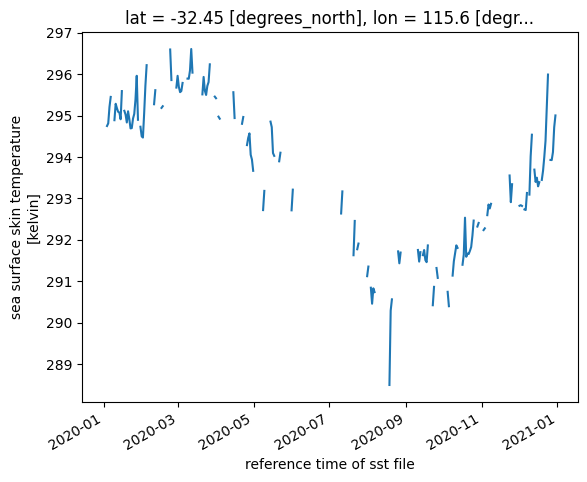

In [8]:
timeseries.sea_surface_temperature.plot()